## Import

In [ ]:
# Import
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import re
from sklearn.datasets import load_files
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras import optimizers
import random
from keras import backend as K
import cv2
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from math import sqrt

## Load files from Drive

In [ ]:
# Load files from Drive
from google.colab import drive
drive.mount('/gdrive/')
dataset = load_files('/gdrive/My Drive/txt_sentoken')
features, labels = dataset.data, dataset.target

Drive already mounted at /gdrive/; to attempt to forcibly remount, call drive.mount("/gdrive/", force_remount=True).


### Cleaning corpus

In [ ]:
# Cleaning corpus

corpus = []
corpus1 = []
for i in range(len(features)):
    review = re.sub(r'\\n', ' ', str(features[i]))
    corpus1.append(review)

for i in range(len(corpus1)):
    # Removing all punctuation marks and non characters
    review = re.sub(r'\W', ' ', str(corpus1[i]))

    # Converting into lowercase
    review = review.lower()

    # Removing b from starting of string
    review = re.sub(r'^b\s+', '', review)

    # Removing all single characters
    review = re.sub(r'\s+[a-z]\s+', ' ', review)

    # Removing all words which is of length one
    review = re.sub(r'[^a-z]\s+', ' ', review)

    # Removing all extra spaces
    review = re.sub(r'\s+', ' ', review)

    # Adding cleaned reviews in corpus
    corpus.append(review)

In [ ]:
nltk.download('wordnet')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def lemmatize_stemming(text): #Lemmatization and Stemming
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))


def preprocess(text):  # Preprocess text
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


processed_docs = []
for i in corpus:
    processed_docs.append(preprocess(i)) # All documents after preprocessing

In [ ]:
tokenizer = Tokenizer(num_words=1500, split=' ') # Tokenization

tokenizer.fit_on_texts(processed_docs)

X = tokenizer.texts_to_sequences(processed_docs)

X = pad_sequences(X)

In [ ]:
labels = labels.reshape(-1, 1)
Y = np.ravel(labels)
# One hot encoding
Y = pd.get_dummies(Y)
Y = np.array(Y)
print(Y)

[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
X.shape
#2000 samples are present

(2000, 751)

## Building the model

In [ ]:
# Building the model
def build_model(inp_length):
  embedding_vector_length = 32
  model = Sequential()
  model.add(Embedding(5000, embedding_vector_length, input_length=inp_length))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(100))
  model.add(Dense(2, activation='sigmoid'))
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  #print(model.summary())
  return model

### Functions

In [ ]:
def mini_batches(X, Y, mini_batch_size=64):
    # Generate batches

    m = X.shape[0]  # number of training examples=1700
    mini_batches = []
    

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(np.floor(m / mini_batch_size))  # number of mini batches of size mini_batch_size in your partitionning=27
    # print(num_complete_minibatches,"-------------------")
    for k in range(0, num_complete_minibatches):
        mini_batch_X = X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :]
        # print(len(mini_batch_X))
        mini_batch_Y = Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = X[num_complete_minibatches * mini_batch_size: m, :]
        mini_batch_Y = Y[num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


def lr_scheduler(epoch, maxepoch, max_lr=0.01, min_lr=0.005, cool_down_lr=0.0005):

      learning_rate = max_lr + (epoch * (min_lr - max_lr) / maxepoch)

      return learning_rate


In [ ]:
def train(args): 

 
  batch_size = args["batch_size"]
  maxepoch = args["maxepoches"]
  min_lr = args["min_lr"]
  max_lr = args["max_lr"]
  cool_down_lr = args["cool_down_lr"]
  lr = args["lr"]
  optimizer = args["optimizer"]
  
  num_classes = args["num_classes"]

  x_train = args["x_train"] 
  y_train = args["y_train"] 
  x_test = args["x_test"] 
  y_test = args["y_test"] 

  num_samples = (x_train.shape)[0]
  num_minibatches = int(np.ceil(num_samples / batch_size))

  total_delta_weights_dense2 = [0] * num_samples
  print("Number of MiniBatches:", num_minibatches)

  model = build_model(X.shape[0])
  
  if optimizer == "sgd":
    opt = optimizers.SGD(lr=lr, momentum=0.9, nesterov=True)
  elif optimizer == "adam":
    opt = optimizers.Adam(learning_rate=min_lr)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  
  
  for epoch in range(maxepoch):
    num_minibatches = int(num_samples / batch_size)
    minibatches = mini_batches(x_train, y_train, batch_size)

 
    learning_rate = lr_scheduler(epoch=epoch, maxepoch=maxepoch, max_lr=max_lr, min_lr=min_lr, cool_down_lr=cool_down_lr)
    
    if optimizer == "sgd":
      opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer == "adam":
      opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("---------------------------------------------------", "Epoch:", epoch+1, "Learning Rate:", learning_rate, "-----------------------------------------------------------------------")
  
    counter = 0
    count = 0

    for minibatch in minibatches:
        
        (train_sample_x, train_sample_y) = minibatch
        # print(len(train_sample_x)) Each minibatch has 64 elements

        # print("SHAPE",len(model.layers[-1].get_weights())) SHAPE: 2
        
        

        pre_weights_dense2 = np.array(model.layers[-1].get_weights()[0]) # before training 64 samples (100 weights)
        

        counter += 1
        

        model.fit(train_sample_x, train_sample_y,
                  batch_size=batch_size,
                  shuffle=False, 
                  epochs=1,
                  verbose=0)

      
        post_weights_dense2 = np.array(model.layers[-1].get_weights()[0])# after training 64 samples (100 weights)
        
        
        delta_weights_dense2 = np.subtract(post_weights_dense2, pre_weights_dense2) # len=100 
        #print(len(delta_weights_dense2),"OVER")

        for i in range(len(train_sample_x)): # for each of 64 training samples
          total_delta_weights_dense2[i + count] = np.add(total_delta_weights_dense2[i + count], delta_weights_dense2)
          # delta_weights_dense2 is repeated for each sample. 

        count += len(train_sample_x)
    
    print("Train Scores:")
    tr_loss, tr_acc = model.evaluate(x=x_train, y=y_train, verbose=1)
    print("Test Scores:")
    val_loss, val_acc = model.evaluate(x=x_test, y=y_test, verbose=1) 
    
    
  return model, total_delta_weights_dense2

### Splitting X and Y into X train, X val, X unseen, Y train, Y val, Y unseen

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

In [ ]:
x_val, x_unseen, y_val, y_unseen = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

### MODEL 1

In [ ]:
my_args = {"batch_size": 1,
"maxepoches": 8,
"min_lr": 0.0001,
"max_lr": 0.001,
"cool_down_lr": 0.0005,
"lr": 0.001,

"optimizer": "adam", # different optimizers: adam, sgd
"num_classes": 2,
"x_train": X_train, 
"y_train": y_train,
"x_test": X_test,
"y_test": y_test
}


model, total_delta_weights_dense2 = train(my_args)

Number of MiniBatches: 1700
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2000, 32)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2000, 32)          3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 216,506
Trainable params: 216,506
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------- Epoch: 1 Learning Rate: 0.001 ----

In [ ]:
X_train.shape

(1700, 751)

In [ ]:
model.save_weights('/gdrive/MyDrive/Model_Weights.h5')

In [ ]:
predicted_y = model.predict_classes(x_val)
predicted_y = pd.get_dummies(predicted_y)
predicted_y = np.array(predicted_y)
residuals = np.argmax(predicted_y,1)!=np.argmax(y_val,1) 
# print(residuals)

loss = sum(residuals)/len(residuals)
print("The Test 0/1 loss is: ", loss)

print("Number of Incorrect samples:", sum(residuals))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[False False False False False False False False False False False False
  True False False False False False False False False False False  True
 False  True False False  True False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False  True False False False False
 False False False  True False False  True False False False False False
  True  True False  True False False False False False False False  True
  True False False False False False False  True False  True False False
 False False  True False  True False  True False  True False  True  True
  True False False False  True False False False  True False False False
 False False False  True False False False False False False False False
 False False False False  True False False False  True False  True  True
 False False False False False False]
The Test 0/1 loss is:  0.19333333333333333
Number of Incorrect samples: 29


In [ ]:
predicted_y_tr = model.predict_classes(X_train, batch_size=1)
predicted_y_tr = pd.get_dummies(predicted_y_tr)
predicted_y_tr = np.array(predicted_y_tr)
residuals_tr = np.argmax(predicted_y_tr,1)!=np.argmax(y_train,1) 
print(residuals_tr)

loss_tr = sum(residuals_tr)/len(residuals_tr)
print("The Train 0/1 loss is: ", loss_tr)

print("Number of Incorrect samples:", sum(residuals_tr))

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[False False False ... False False False]
The Train 0/1 loss is:  0.0035294117647058825
Number of Incorrect samples: 6


### Final Data for the Second Model 

In [ ]:
# Final Data for the Second Model 

incorrect_indecies = list([i for i, x in enumerate(residuals) if x])
correct_indecies = [a for a in range(x_val.shape[0]) if a not in incorrect_indecies]

print(len(incorrect_indecies), "+", len(correct_indecies), "=", len(x_val))


incorrect_samples = []
incorrect_x = []
incorrect_y = []
incorrect_y_true = []
incorrect_y_pred = []
# All (X_train+x_val) values which were wrongly predicted.

for ind in incorrect_indecies:
  incorrect_x.append(x_val[ind])
  incorrect_y.append(0.0)
  incorrect_y_true.append(y_val[ind])
  incorrect_y_pred.append(predicted_y[ind])
len_incorrect_x=len(incorrect_x)
print("Only incorrectly predicts of x test: ",len(incorrect_x))


incorrect_indecies_tr = list([i for i, x in enumerate(residuals_tr) if x]) # incorrect X_train 

for ind_tr in incorrect_indecies_tr:
  incorrect_x.append(X_train[ind_tr])
  incorrect_y.append(0.0)
  incorrect_y_true.append(y_train[ind_tr])
  incorrect_y_pred.append(predicted_y_tr[ind_tr])

print("Incorrects Done! \nLength =", len(incorrect_x))
print("Length of Wrong x train predicts = ",len(incorrect_x)-len_incorrect_x )



*Wrongly predicts are << Correctly predicted* 





In [ ]:
correct_indecies = random.sample(correct_indecies, len(incorrect_x)) # sampled only from correctly predicts X_test

correct_samples = []
correct_x = []
correct_y = []
correct_y_true = []
correct_y_pred = []
for ind in correct_indecies:
  correct_x.append(x_val[ind]) # prev comment makes sense
  correct_y.append(1.0) # 1 means correctly predicted
  correct_y_true.append(y_val[ind])
  correct_y_pred.append(predicted_y[ind])

print("Corrects Done! \nLength =", len(correct_x))

In [ ]:
def shuffle_in_unison(a, b, c, d):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)
    np.random.set_state(rng_state)
    np.random.shuffle(d)

    return a, b, c, d

In [ ]:
x_train_list = correct_x + incorrect_x
y_train_list = correct_y + incorrect_y
y_true_list = correct_y_true + incorrect_y_true
y_pred_list = correct_y_pred + incorrect_y_pred

final_x_train = np.array(x_train_list)
final_y_train = np.array(y_train_list)
final_y_true = np.array(y_true_list)
final_y_pred = np.array(y_pred_list)

final_x_train, final_y_train, final_y_true, final_y_pred = shuffle_in_unison(final_x_train, final_y_train, final_y_true, final_y_pred)

print("Final X and Y Shape:", final_x_train.shape, final_y_train.shape, final_y_true.shape, final_y_pred.shape)

In [ ]:
X_train.shape

In [ ]:
model = build_model(751)
model.load_weights('/gdrive/MyDrive/Model_Weights.h5')

In [ ]:
# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)


In [ ]:
# Locate the most similar neighbors
def get_neighbors(train,y_train,y_truee,test_row, num_neighbors):
  distances = list()
  x_count=-1
  for train_row in train:
    x_count+=1
    dist = euclidean_distance(test_row, train_row)
    # print(y_train[x_count],"------true",y_truee)
    if y_train[x_count]==y_truee:
      distances.append((train_row, dist))
      
    distances.sort(key=lambda tup: tup[1])
  neighbors = list()
  for i in range(num_neighbors):
    neighbors.append(distances[i][0])
 
  return neighbors[0]

In [ ]:
y_FULL_for_function=np.argmax(y_train, axis=1)
y_FULL_for_function

array([0, 0, 1, ..., 1, 0, 1])

In [ ]:
len(final_x_train)

70

In [ ]:
XY_tuples = []
for i in range(len(final_x_train)):
    sample = final_x_train[i]
    # print(sample.reshape(751,))
    
    prediction = final_y_train[i]
    y_truee = final_y_true[i]
    y_pred = final_y_pred[i]

    print("y true:", y_truee)
    # print("ypred:", y_pred)
    # print("prediction:", prediction)

    y_F=np.argmax(y_pred, axis=0)
    # print(y_F)

    nearest_neighbor=get_neighbors(X_train,y_FULL_for_function,y_F,sample,1)
    # print(nearest_neighbor)
    XY_tuples.append((sample, nearest_neighbor, prediction, y_truee, y_pred))


y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [0 1]
y true: [0 1]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [0 1]
y true: [1 0]
y true: [1 0]
y true: [0 1]


In [ ]:
len(XY_tuples)

70

In [ ]:
XY_tuples[55][4]

array([0, 1], dtype=uint8)

### Unseen Data

In [ ]:
# Generating Data for Model 2

predicted_y_un = model.predict(x_unseen, batch_size=1)
# print(predicted_y_un)
# predicted_y_un = pd.get_dummies(predicted_y_un)
# predicted_y_un = np.array(predicted_y_un)

residuals_un = np.argmax(predicted_y_un,1)!=np.argmax(y_unseen,1)
print(residuals_un)
loss_un = sum(residuals_un)/len(residuals_un)
print("The Test 0/1 loss is: ", loss_un)

print("Number of Incorrect samples:", sum(residuals_un))

[False False  True False False False False  True  True False False False
 False False False False False False False  True False False False False
 False False False False False False False  True  True False  True False
  True False  True False False False False  True False  True False False
 False  True  True False False False False False  True False False False
 False  True False False  True False  True False False False False False
 False False  True False False False False  True False False  True False
 False  True False False False False False False False False False False
 False False False False  True False False False False False  True False
 False False  True False False  True False False False  True False  True
 False  True  True  True  True False False False False False False False
  True  True False False  True False False False  True False False  True
 False False  True  True False False]
The Test 0/1 loss is:  0.25333333333333335
Number of Incorrect samples: 38


In [ ]:
# Generating Data for Model 2

incorrect_indecies = list([i for i, x in enumerate(residuals_un) if x])
correct_indecies = [a for a in range(x_unseen.shape[0]) if a not in incorrect_indecies]

print(len(incorrect_indecies), "+", len(correct_indecies), "=", len(x_unseen))


# correct_indecies = random.sample(correct_indecies, len(incorrect_indecies))

incorrect_samples = []
incorrect_x = []
incorrect_y = []
incorrect_y_true = []
incorrect_y_pred = []
for ind in incorrect_indecies:
  incorrect_x.append(x_unseen[ind])
  incorrect_y.append(0.0)
  incorrect_y_true.append(y_unseen[ind])
  incorrect_y_pred.append(predicted_y_un[ind])



correct_samples = []
correct_x = []
correct_y = []
correct_y_true = []
correct_y_pred = []
for ind in correct_indecies:
  correct_x.append(x_unseen[ind])
  correct_y.append(1.0)
  correct_y_true.append(y_unseen[ind])
  correct_y_pred.append(predicted_y_un[ind])

x_train_list = correct_x + incorrect_x
y_train_list = correct_y + incorrect_y
y_true_list = correct_y_true + incorrect_y_true
y_pred_list = correct_y_pred + incorrect_y_pred

final_x_train = np.array(x_train_list)
final_y_train = np.array(y_train_list)
final_y_true = np.array(y_true_list)
final_y_pred = np.array(y_pred_list)

final_x_train, final_y_train, final_y_true, final_y_pred = shuffle_in_unison(final_x_train, final_y_train, final_y_true, final_y_pred)

print("Final X and Y Shape:", final_x_train.shape, final_y_train.shape, final_y_true.shape, final_y_pred.shape)

38 + 112 = 150
Final X and Y Shape: (150, 751) (150,) (150, 2) (150, 2)


In [ ]:
XY_tuples_unseen = []
for i in range(len(final_x_train)):
  sample = final_x_train[i]
  prediction = final_y_train[i]
  y_truee = final_y_true[i]
  y_pred = final_y_pred[i]

  # print("y true:", y_truee)
  # print("ypred:", y_pred)
  # print("prediction:", prediction)

  y_F=np.argmax(y_truee, axis=0)
  print(y_F)

  nearest_neighbor=get_neighbors(X_train,y_FULL_for_function,y_F,sample,1)
  # print(nearest_neighbor)
  XY_tuples_unseen.append((sample, nearest_neighbor, prediction, y_truee, y_pred))
  



y true: [1 0]
ypred: [9.996792e-01 3.154300e-04]
prediction: 1.0
0
y true: [0 1]
ypred: [0.00288211 0.996924  ]
prediction: 1.0
1
y true: [0 1]
ypred: [0.00601623 0.99466753]
prediction: 1.0
1
y true: [1 0]
ypred: [1.1670481e-04 9.9989998e-01]
prediction: 0.0
0
y true: [1 0]
ypred: [0.99879175 0.00111354]
prediction: 1.0
0
y true: [0 1]
ypred: [0.02879657 0.9764395 ]
prediction: 1.0
1
y true: [1 0]
ypred: [8.153853e-05 9.998982e-01]
prediction: 0.0
0
y true: [0 1]
ypred: [7.000936e-05 9.999318e-01]
prediction: 1.0
1
y true: [0 1]
ypred: [0.9990351  0.00108908]
prediction: 0.0
1
y true: [0 1]
ypred: [0.9888362  0.01098956]
prediction: 0.0
1
y true: [1 0]
ypred: [5.375681e-04 9.994418e-01]
prediction: 0.0
0
y true: [1 0]
ypred: [0.99864405 0.00156915]
prediction: 1.0
0
y true: [1 0]
ypred: [0.99660933 0.00231836]
prediction: 1.0
0
y true: [1 0]
ypred: [9.9966979e-01 3.2931214e-04]
prediction: 1.0
0
y true: [0 1]
ypred: [4.824833e-04 9.995309e-01]
prediction: 1.0
1
y true: [0 1]
ypred: [0

In [ ]:
str(len(XY_tuples_unseen)) +" <--Unseen   Train--> "+ str(len(XY_tuples))

'150 <--Unseen   Train--> 70'

### Load data for second model

In [ ]:
def load_data(train_tuples, unseen_tuples):
  
  samples = []
  resp_samples = []
  y = []
  y_trues = []
  y_preds = []
  for tpl in train_tuples:
    samples.append(tpl[0])
    resp_samples.append(tpl[1])
    y_trues.append(tpl[3])
    y_preds.append(tpl[4])

    if tpl[2] == 0:
      y.append([1.0,0.0])
    elif tpl[2] == 1:
      y.append([0.0,1.0])

  unseen_samples = []
  unseen_resp_samples = []
  unseen_y = []
  unseen_y_trues = []
  unseen_y_preds = []
  for unseen_tpl in unseen_tuples:
    unseen_samples.append(unseen_tpl[0])
    unseen_resp_samples.append(unseen_tpl[1])
    unseen_y_trues.append(unseen_tpl[3])
    unseen_y_preds.append(unseen_tpl[4])

    if unseen_tpl[2] == 0:
      unseen_y.append([1.0,0.0])
    elif unseen_tpl[2] == 1:
      unseen_y.append([0.0,1.0])

  samples, unseen_samples = np.array(samples), np.array(unseen_samples)
  resp_samples, unseen_resp_samples = np.array(resp_samples), np.array(unseen_resp_samples)


  y = np.array(y)
  unseen_y = np.array(unseen_y)

  print('Training Data:')
  print("Input Image Shapes:", samples.shape, resp_samples.shape)
  print("Output shape:", y.shape)

  print('Unseen Data:')
  print("Input Image Shapes:", unseen_samples.shape, unseen_resp_samples.shape)
  print("Output shape:", unseen_y.shape)
  return samples, resp_samples, y, y_trues, y_preds, unseen_samples, unseen_resp_samples, unseen_y, unseen_y_trues, unseen_y_preds

In [ ]:
samples, resp_samples, y, y_trues, y_preds, samples_unseen, resp_samples_unseen, y_unseen, y_trues_unseen, y_preds_unseen = load_data(XY_tuples, XY_tuples_unseen)

Training Data:
Input Image Shapes: (70, 751) (70, 751)
Output shape: (70, 2)
Unseen Data:
Input Image Shapes: (150, 751) (150, 751)
Output shape: (150, 2)


In [ ]:
train_index=range(len(samples))
y_train=y

train_samples = []
train_resps = []
train_trues = []
train_preds = []

# y_train = []
for ind in train_index:
  train_samples.append(samples[ind])
  train_resps.append(resp_samples[ind])
  train_trues.append(y_trues[ind])
  train_preds.append(y_preds[ind])
  # y_train.append(y[ind])

train_samples = np.array(train_samples)
train_resps = np.array(train_resps)
train_trues = np.array(train_trues)
train_preds = np.array(train_preds)
# y_train = np.array(y_train)



print("Training set:", train_resps.shape, train_samples.shape, y_train.shape, train_preds.shape, train_trues.shape)


Training set: (70, 751) (70, 751) (70, 2) (70, 2) (70, 2)


### Functions

In [ ]:
def train(args): 
  batch_size = args["batch_size"]
  maxepoch = args["maxepoches"]
  min_lr = args["min_lr"]
  max_lr = args["max_lr"]
  cool_down_lr = args["cool_down_lr"]
  lr = args["lr"]
  
  optimizer = args["optimizer"]
  train_samples = args["train_samples"]

  train_resps = args["train_resps"]

  y_train = args["y_train"]


  model = None

  def lr_scheduler(epoch):
      if epoch <= 0.6 * maxepoch:
        learning_rate = max_lr
      else:
        learning_rate = max_lr + ((epoch + 1 - (0.6 * maxepoch)) * (min_lr - max_lr) / (0.4 * maxepoch) )
      print("Epoch:", epoch, "Learning Rate:", learning_rate)
      return learning_rate



  model = build_model(751*2)
  reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
  if optimizer == "sgd":
    opt = optimizers.SGD(learning_rate=min_lr, momentum=0.9, nesterov=True)
  elif optimizer == "adam":
    opt = optimizers.Adam(learning_rate=min_lr)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  model.summary()
  # plot_model(model, to_file="/content/drive/MyDrive/Responsibility_Comparison/New_Dataset/" + model_type + ".png", show_shapes=True, show_layer_names=True)

  x_train = np.concatenate((train_samples, train_resps), axis=1)
  print(x_train.shape)
  history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    # steps_per_epoch=samples.shape[0] // batch_size,
                    shuffle=True, 
                    epochs=maxepoch,
                    validation_split=0.2,
                    callbacks=[reduce_lr],
                    verbose=1)
  
  return model, history

In [ ]:
train_resps.shape

(70, 751)

### Training second model

In [ ]:
my_args = {"batch_size": 15,
"maxepoches": 50,
"min_lr": 0.001,
"max_lr": 0.01,
"cool_down_lr": 0.00001,
"lr": 0.001,

"optimizer": "adam", # different optimizers: adam, sgd
"train_samples": train_samples, 

"train_resps": train_resps,

"y_train": y_train,
}

model, hist = train(my_args)


### Plot

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


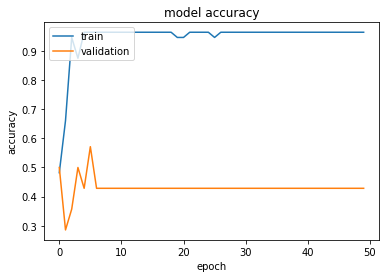

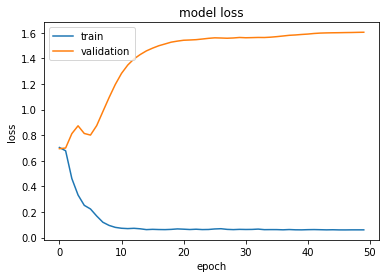

In [ ]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Final Evaluation

In [ ]:
print("Evaluation on Unseen Dataset:")

x_test = np.concatenate((samples_unseen, resp_samples_unseen), axis=1)
# print(x_test[1])

model.evaluate(x_test, y_unseen)
y_hat = model.predict(x_test)

y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_unseen, axis=1)
# print(y_pred[0],"ddddd",y_unseen[0])

my_precision = precision_score(y_true, y_pred)
my_recal = recall_score(y_true, y_pred)
my_f1 = f1_score(y_true, y_pred)
print(accuracy_score(y_true,y_pred))
print("Precision:", my_precision, "Recall:", my_recal, "f1 score:", my_f1)

Evaluation on Unseen Dataset:
5/5 [==============================] - 0s 42ms/step - loss: 1.3570 - accuracy: 0.6267
0.6266666666666667
Precision: 0.8043478260869565 Recall: 0.6607142857142857 f1 score: 0.7254901960784315
